## **Pomocne moduly**

In [1]:
import itertools
import math
import numpy as np
import UQpy
from scipy.special import comb
from UQpy.distributions import Uniform,Normal, JointIndependent
from UQpy.surrogates.polynomial_chaos import TotalDegreeBasis, LeastSquareRegression
from UQpy.sensitivity import PceSensitivity
from UQpy.sampling import MonteCarloSampling
from sklearn.metrics import mean_squared_error, r2_score
import time  
import scipy as sp
import random
import matplotlib.pyplot as plt

import SAPCE

In [2]:

def root_mean_squared_error(y_true, y_pred, multioutput='uniform_average'):
    mse = mean_squared_error(y_true, y_pred, multioutput=multioutput)
    if isinstance(mse, np.ndarray):
        return np.sqrt(mse)
    return np.sqrt(mse)


In [3]:
import pandas as pd
data = pd.read_csv('Oakwood.csv', sep=';', header=0)
data_NVM= pd.read_csv('Oakwood_NVM.csv', sep=';', header=0)

names=data.columns.tolist()
data_array=data.to_numpy()

names_NVM=data_NVM.columns.tolist()
data_array_NVM=data_NVM.to_numpy()

In [4]:
X=data_array[:,:12]
Y_all=data_array[:,12:]
Y_tunnel=data_array[:,12:23]
Y_surface=data_array[:,23:]

Y_all_NVM=data_array_NVM[:,12:]

Y_N=Y_all_NVM[:,:113]
Y_V=Y_all_NVM[:,113:226]
Y_M=Y_all_NVM[:,226:]

In [5]:
Y_all.shape

(1000, 23)

In [6]:
# Concrete parameters
dist_Ec=Normal(13,1)
dist_Relax=Uniform(30,40)

# Soil1
dist_S1_Erel=Uniform(2,1)
dist_S1_E50=Normal(65,5)
dist_S1_c=Normal(30,5)
dist_S1_theta=Normal(30,1)
dist_S1_ko=Uniform(0.6,0.5)

# Soil2
dist_S1_Erel=Uniform(2,1)
dist_S1_E50=Normal(130,10)
dist_S1_c=Normal(5,1)
dist_S1_theta=Normal(42,1)
dist_S1_ko=Uniform(0.45,0.2)


marg = [dist_Ec,dist_Relax, dist_S1_Erel, dist_S1_E50, dist_S1_c,dist_S1_theta,dist_S1_ko,dist_S1_Erel,dist_S1_E50,dist_S1_c,dist_S1_theta,dist_S1_ko]
joint = JointIndependent(marginals=marg)

0
Adaptive basis construction terminated: basis cardinality reached experimental design size.
Adaptive basis construction terminated: basis cardinality reached experimental design size.
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1294.110522683898
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1000.8660563507633
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1415.2734703256458
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1078.2381504085872
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 2288.709555265102
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1280.7272811133778
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1840.964262699166
Adaptive basis construction terminated: design matrix not suf

Text(0.5, 0, '$n_{sim}$')

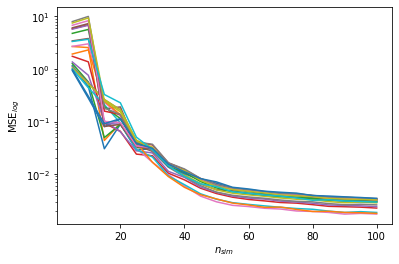

In [7]:
errs_stat=[]

# statitical replications (scatter of errors)
for s in range(50):
    print(s)
    errs=[]
    nsim=[]
    # number of simulations (increasing)
    for i in range(1,21):
        nsim.append(5*i)

        rand_indices=random.sample(range(len(Y_all)), nsim[-1])
        xx_train=X[rand_indices,:]
        yy_train=Y_all[rand_indices,:]
        
        xx_val=np.delete(X, rand_indices)
        yy_val=np.delete(Y_all, rand_indices)

        
        sapce = SAPCE.SensitivityAdaptivePCE(pdf=joint, exp_design_in=xx_train, exp_design_out=yy_train, max_partial_degree=10, num_inputs=12)
        sapce.construct_adaptive_basis(max_condition_number=1e3)
        sapce.construct_pruned_pce(cr=1e-8)

        errs.append(sapce.pce.validation_error(X,Y_all))
        
    
    errs_stat.append(errs)

    
errs_stat_array=np.array(errs_stat)



fig, ax = plt.subplots()

for i in range(21):
    ax.plot(nsim,np.mean(errs_stat_array[:,:,2+i],axis=0),label='sim {}'.format(i))
    
ax.set_yscale('log')
# ax.legend()
ax.set_ylabel('MSE$_{log}$')
ax.set_xlabel('$n_{sim}$')

# fig.savefig('results_displacements.pdf')

0
Adaptive basis construction terminated: basis cardinality reached experimental design size.
Adaptive basis construction terminated: basis cardinality reached experimental design size.
Adaptive basis construction terminated: basis cardinality reached experimental design size.
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1465.1749410950906
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1085.4048891530017
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1104.051190871782
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 2007.515070114964
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1135.9148486765453
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1376.1446640841875
Adaptive basis construction terminated: design matrix not sufficiently well-

Text(0.5, 0, '$n_{sim}$')

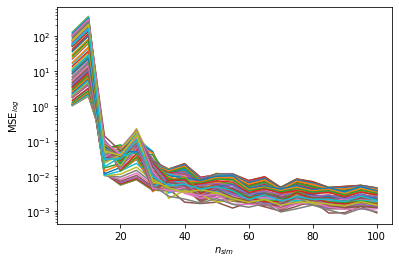

In [13]:
# single PCE for further evalutions (no statistical replications)
errs_stat=[]

for s in range(1):
    print(s)
    errs=[]
    nsim=[]
    for i in range(1,21):
        nsim.append(5*i)

        rand_indices=random.sample(range(len(Y_all)), nsim[-1])
        xx_train=X[rand_indices,:]
        yy_train=Y_all_NVM[rand_indices,:]
        
        xx_val=np.delete(X, rand_indices)
        yy_val=np.delete(Y_all_NVM, rand_indices)


        sapce = SAPCE.SensitivityAdaptivePCE(pdf=joint, exp_design_in=xx_train, exp_design_out=yy_train, max_partial_degree=10, num_inputs=12)
        sapce.construct_adaptive_basis(max_condition_number=1e3)
        sapce.construct_pruned_pce(cr=1e-8)

        errs.append(sapce.pce.validation_error(X,Y_all_NVM))
        
    
    errs_stat.append(errs)

    
errs_stat_array=np.array(errs_stat)



fig, ax = plt.subplots()

for i in range(len(yy_train)):
    ax.plot(nsim,np.mean(errs_stat_array[:,:,i],axis=0),label='sim {}'.format(i))
    
ax.set_yscale('log')
# ax.legend()
ax.set_ylabel('MSE$_{log}$')
ax.set_xlabel('$n_{sim}$')

# fig.savefig('results_displacements.pdf')

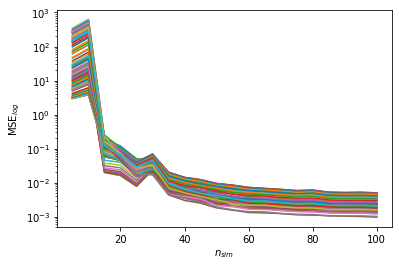

In [36]:

fig, ax = plt.subplots()

for i in range(len(yy_train)):
    ax.plot(nsim,np.mean(errs_stat_array[:,:,i],axis=0),label='sim {}'.format(i))
    
ax.set_yscale('log')
# ax.legend()
ax.set_ylabel('MSE$_{log}$')
ax.set_xlabel('$n_{sim}$')

# fig.savefig('results_NVM.pdf')
# np.save('test_SAPCE.npy',errs_stat_array )

In [33]:
sapce.pce.coefficients

array([[-1.29407569e+06, -1.29750488e+06, -1.30464580e+06, ...,
         1.84374308e+04,  1.66243259e+04,  1.55585777e+04],
       [-2.35233117e+04, -2.34149433e+04, -2.31231536e+04, ...,
        -3.28104083e+03, -3.25484357e+03, -3.25534707e+03],
       [-8.73704789e+03, -8.76934622e+03, -8.81745359e+03, ...,
         1.25678577e+03,  8.52493045e+02,  6.45472079e+02],
       ...,
       [-2.58296073e+01, -2.50807911e+01, -2.40374087e+01, ...,
        -2.87571470e+01, -3.00506062e+01, -2.82995531e+01],
       [ 8.11006860e+01,  8.07129751e+01,  7.96641642e+01, ...,
         3.34254144e+01,  3.28352765e+01,  3.14363829e+01],
       [ 1.30985823e+02,  1.29931689e+02,  1.26815552e+02, ...,
        -8.64174592e+01, -9.16086997e+01, -8.84293242e+01]])

In [9]:


# plt.rcParams['axes.linewidth'] = 0.5
# plt.rcParams['text.usetex']=True
# #plt.rc('text.latex', preamble=r'\usepackage[bitstream-charter]{mathdesign}')
# plt.rcParams['font.size'] = 10
# plt.rcParams['xtick.major.width'] = 0.5
# plt.rcParams['ytick.major.width'] = 0.5
# # Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
# plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}) 

# import matplotlib
# matplotlib.use('pgf')
# plt.rcParams["pgf.texsystem"] = "xelatex"
# plt.rcParams["pgf.rcfonts"] = False

# preamble = r'''\usepackage[utf8]{inputenc} %unicode support
# \usepackage[czech]{babel}
# \usepackage[T1]{fontenc}
# \DeclareMathAlphabet{\pazocal}{OMS}{zplm}{m}{n}
# \usepackage{calrsfs}
# \usepackage{amsmath}
# \usepackage{bm}
# \usepackage[bitstream-charter]{mathdesign}
# '''
# plt.rc('text.latex', preamble=preamble)
# plt.rcParams["pgf.preamble"] = preamble

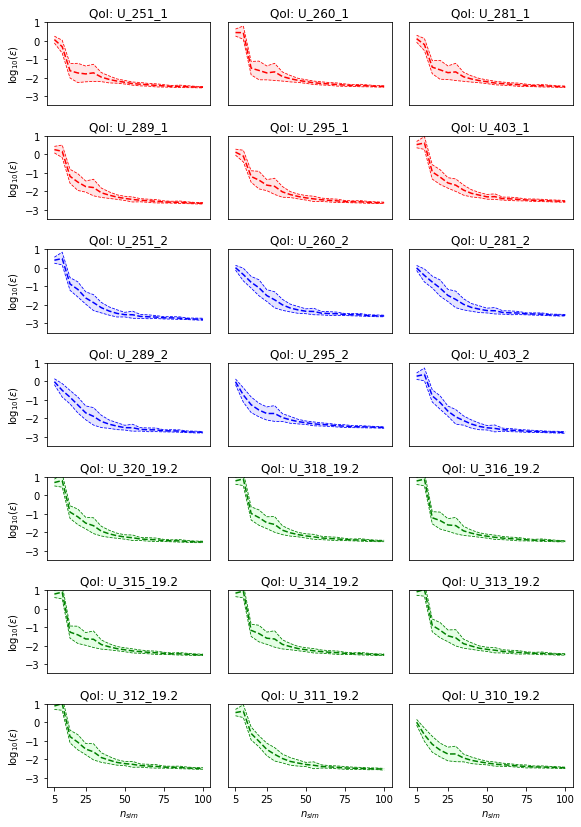

In [15]:
def logplot (vals):
    vals=np.log10(vals)
    delta=(np.std(np.array(vals)))
    means=(np.mean(np.array(vals)))
    maxy=(np.mean(np.array(vals))+delta)
    miny=(np.mean(np.array(vals))-delta)
    if means<-10:
        means=-10
        maxy=-10
        miny=-10
    return means,maxy,miny



sims=len(nsim)
fig, axis = plt.subplots(7,3,figsize=(8.2,11.6))

j=0
for ax in axis.flatten():
    means=np.zeros(sims)
    maxs=np.zeros(sims)
    mins=np.zeros(sims)

    for i in range(sims):
        means[i],maxs[i],mins[i]=logplot(errs_stat_array[:,i,j+2])
        
    ax.set_title('QoI: {}'.format(names[12+j]))  
    ax.set_ylim(-3.5,1)
    ax.set_yticks([])
    ax.set_xticks([])
    
    if j<6:
        color='red'
        color_hex=(1,0,0,0.1)
        
    elif j<12:
        color='blue'
        color_hex=(0,0,1,0.1)
        
    else:
        color='green'
        color_hex=(0,1,0,0.1)
    ax.plot(nsim,means,'--',c=color)
    ax.plot(nsim,mins,'--',c=color,linewidth=0.8)
    ax.plot(nsim,maxs,'--',c=color,linewidth=0.8)
    ax.fill_between(nsim, mins, maxs, facecolor=color_hex)

    j=j+1
    


j=0
for ax in axis.flatten():
    if j%3==0:
        ax.set_yticks([1,0,-1,-2,-3])
        ax.set_ylabel('log$_{10}$($\epsilon$)')
    j=j+1
    
    if j>18:
        ax.set_xticks([5,25,50,75,100])
        ax.set_xlabel('$n_{sim}$')
    
fig.tight_layout()
# fig.savefig('results_displacements.pdf')

In [26]:
names[12+j]

'U_251_1'

In [ ]:
nsim.append(200)

rand_indices=random.sample(range(len(Y_all)), nsim[-1])
xx_train=X[rand_indices,:]
yy_train=Y_all[rand_indices,:]

xx_val=np.delete(X, rand_indices)
yy_val=np.delete(Y_all, rand_indices)


sapce = SAPCE.SensitivityAdaptivePCE(pdf=joint, exp_design_in=xx_train, exp_design_out=yy_train, max_partial_degree=10,tolerance=1e-3, num_inputs=12)
sapce.construct_adaptive_basis(max_condition_number=1e4)
sapce.construct_pruned_pce(cr=1e-8)

In [9]:

mean=np.mean(Y_all,axis=0)
var=np.var(Y_all,axis=0)
pcemean= sapce.pce.get_moments()[0]
pcevar= sapce.pce.get_moments()[1]


print("\nStřední hodnota:", mean)
print(" PCE mean:",pcemean)
print("\nVariance:", var)
print(" PCE var:",pcevar)





Střední hodnota: [ 5.00000000e-07  2.46750000e-03 -3.07652786e-03 -9.18902886e-03
 -4.45826169e-03 -6.86842784e-03 -3.40341821e-03 -9.40788294e-03
 -6.65869071e-03 -7.56966944e-04 -1.59107141e-04 -5.23323768e-04
 -1.48367794e-04 -3.32720659e-03 -1.06350163e-02 -1.63168368e-02
 -2.39782108e-02 -2.80467997e-02 -2.47068306e-02 -1.80552260e-02
 -1.16430288e-02 -3.51226917e-03 -2.90005484e-04]
 PCE mean: [ 6.04851552e-06  2.25694255e-03 -3.84110919e-03 -9.49113820e-03
 -4.60025791e-03 -6.95388210e-03 -3.68741424e-03 -9.19814391e-03
 -6.31716589e-03 -7.08674579e-04 -1.24107225e-04 -4.74991176e-04
  9.83488156e-06 -2.99659995e-03 -1.03751883e-02 -1.65611853e-02
 -2.44848213e-02 -2.87316630e-02 -2.51619976e-02 -1.81948492e-02
 -1.16443164e-02 -3.55207364e-03 -1.75427415e-04]

Variance: [2.49750000e-10 2.16937500e-08 9.59694675e-07 6.38535830e-07
 9.72329542e-07 7.03612622e-07 4.86824999e-07 3.90455289e-07
 2.41246352e-07 1.46733334e-07 1.35612945e-07 2.71741199e-07
 5.77082471e-08 7.15598237e